In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from asinh_cmap import asinh_cmap

In [2]:
subject_id = 21686510
model_type = 'aggregate'

In [4]:
models = pd.read_pickle('lib/models.pickle')
err_df = pd.read_csv('lib/errors.csv', index_col=0, header=[0, 1])
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')
model_dict = models.loc[subject_id][model_type]
diff_data = diff_data_df.loc[subject_id]
psf = diff_data['psf']
data = diff_data['galaxy_data']
sigma_image = diff_data['sigma_image']

In [5]:
def plot_difference(diff, ax=None):
    ax = ax if ax is not None else plt.gca()
    l = np.abs(diff).max()
    ax.imshow(diff, cmap='seismic', vmin=-l, vmax=l)

In [38]:
param_errs = err_df.loc[subject_id].replace(0, np.nan).drop(
    [(k, c) for k in ('disk', 'bulge', 'bar') for c in ('I', 'n', 'c')]
).dropna()
param_errs

component  parameter
bulge      Re           0.043766
           mux          0.067712
           muy          0.227813
           q            0.000002
           roll         0.083625
disk       Re           0.631364
           mux          0.517148
           muy          0.748476
           q            0.068873
           roll         1.618317
Name: 21686510, dtype: float64

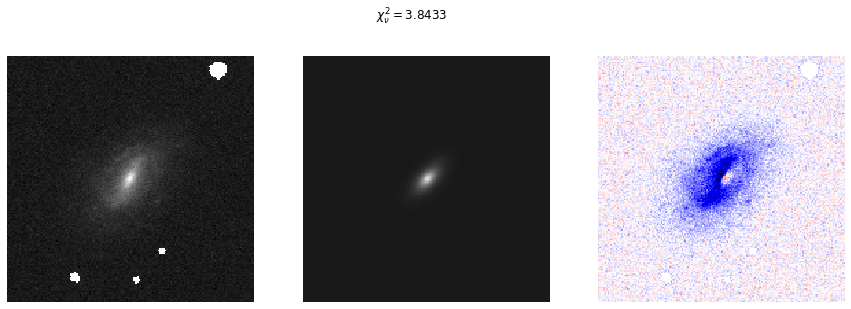

In [18]:
model_obj = fitting.Model(
    model_dict,
    data,
    psf=psf,
    sigma_image=sigma_image,
    param_sigma=param_errs
)
r = model_obj.render()
kw = dict(
    cmap=asinh_cmap,
    vmin=min(data.min(), r.min()),
    vmax=max(data.max(), r.max())
)
f, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(model_obj.data, **kw)
ax[1].imshow(model_obj.render(), **kw)
# ax[2].imshow(r - data, cmap='seismic', vmin=-1, vmax=1)
plot_difference(r - data, ax[2])
cq = fitting.chisq(r, data, sigma_image)
plt.suptitle(r'$\chi_\nu^2 = {:.4f}$'.format(cq))
[a.axis('off') for a in ax];

In [25]:
model_obj.nnlf(model_obj.params)

91843.9914591986

In [27]:
model_obj.params.unstack()

parameter,I,Re,c,falloff,mux,muy,n,q,roll,spread
component,,,,,,,,,,
bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulge,0.2,1.353338,2.0,NaN,90.517752,89.390754,1.0,0.461605,0.390827,NaN
disk,0.2,9.081119,2.0,NaN,90.247849,89.821138,1.0,0.501234,0.762166,NaN
spiral0,0.1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.5


We will reparametrize secondary components to be with respect to the disk

|Original | New        | Limits |
|---------|------------|--------|
| $R_e$   | $\frac{R_e}{R_{e, \mathrm{disc}}}$ | (0, 1) |
| $I$     | $\frac{L_{tot}}{L_{tot} + L_{tot, \mathrm{disc}}}$  | (0, 1) |
| $\mu$     | $\mu - \mu_\mathrm{disc}$  | (-inf, inf) | 

Sersic total luminosity is given by

$$L_{\mathrm{tot}} = 2\pi\,IR_e^2n\frac{e^{b_n}}{(b_n)^{2n}}\Gamma(2n)$$

In [28]:
def sersic_ltot(comp):
    return (
        2 * np.pi * comp['I'] * comp['Re']**2 * comp['n']
        * np.exp(_b(comp['n'])) / _b(comp['n'])**(2 * comp['n'])
        * gamma(2 * comp['n'])
    )


def sersic_I(comp):
    return comp['L'] / (
        2 * np.pi * comp['Re']**2 * comp['n']
        * np.exp(_b(comp['n'])) / _b(comp['n'])**(2 * comp['n'])
        * gamma(2 * comp['n'])
    )

In [29]:
def get_new_params(p):
    # go from original param specification to new
    p_new = p.copy()
    disk_l = sersic_ltot(p['disk'])
    p_new[('disk', 'L')] = disk_l
    p_new.drop(('disk', 'I'), inplace=True)
    for c in ('bulge', 'bar'):
        try:
            comp_l = sersic_ltot(p[c])
            p_new[(c, 'Re')] =  p[(c, 'Re')] / p[('disk', 'Re')]
            p_new[(c, 'mux')] =  p[(c, 'mux')] - p[('disk', 'mux')]
            p_new[(c, 'muy')] =  p[(c, 'muy')] - p[('disk', 'muy')]
            p_new[(c, 'L')] =  sersic_ltot(p[c]) / (disk_l + comp_l)
            p_new.drop((c, 'I'), inplace=True)
        except KeyError:
            pass
    return p_new

def get_original_params(p):
    # go from new param specification to original
    p_new = p.copy()
    disk_I = sersic_I(p['disk'])
    p_new[('disk', 'I')] = disk_I
    p_new.drop(('disk', 'L'), inplace=True)
    for c in ('bulge', 'bar'):
        try:
            p_new[(c, 'Re')] =  p[(c, 'Re')] * p[('disk', 'Re')]
            p_new[(c, 'mux')] =  p[(c, 'mux')] + p[('disk', 'mux')]
            p_new[(c, 'muy')] =  p[(c, 'muy')] + p[('disk', 'muy')]
            comp_l = p[('disk', 'L')] * p[(c, 'L')] / (1 - p[(c, 'L')])
            p_new[(c, 'L')] = comp_l
            p_new[(c, 'I')] = sersic_I(p_new[c])
            p_new.drop((c, 'L'), inplace=True)
        except KeyError as e:
            pass
    return p_new

In [30]:
def get_bulge_tot(params):
    b = sersic_ltot(params['bulge'])
    return b / (b + sersic_ltot(params['disk']))

Get the model's parameters in the new parameterization

In [31]:
all_p = get_new_params(model_obj.params.dropna())

Define limts on parameters:

In [32]:
lims_df = pd.DataFrame([], index=all_p.index, columns=('lower', 'upper'))

lims_df['lower'] = -np.inf
lims_df['upper'] = np.inf

lims_df.loc[('disk', 'L')] = (0, np.inf)
lims_df.loc[('disk', 'Re')] = (0, np.inf)
lims_df.loc[('disk', 'q')] = (0.01, 100)
lims_df.drop(('disk', 'n'), inplace=True)
lims_df.drop(('disk', 'c'), inplace=True)

if model_obj['bulge'] is not None:
    lims_df.loc[('bulge', 'L')] = (0, 1)
    lims_df.loc[('bulge', 'Re')] = (0, 10)
    lims_df.loc[('bulge', 'q')] = (0.01, 100)
    lims_df.loc[('bulge', 'n')] = (0.5, 10)
    lims_df.drop(('bulge', 'c'), inplace=True)
if model_obj['bar'] is not None:
    lims_df.loc[('bar', 'L')] = (0, 1)
    lims_df.loc[('bar', 'Re')] = (0, 10)
    lims_df.loc[('bar', 'q')] = (0.01, 100)
    lims_df.loc[('bar', 'n')] = (0.1, 10)
    lims_df.loc[('bar', 'c')] = (0.01, 10)
if len(model_obj['spiral']) > 0:
    for i in range(len(model_obj['spiral'])):
        lims_df.loc[(f'spiral{i}', 'I')] = (0, np.inf)
        lims_df.loc[(f'spiral{i}', 'spread')] = (0, np.inf)
        lims_df.loc[(f'spiral{i}', 'falloff')] = (0.01, np.inf)

lims_df.sort_index(inplace=True)
lims_df.T

component bulge                                    disk                 \
parameter     L    Re  mux  muy     n       q roll    L   Re  mux  muy   
lower       0.0   0.0 -inf -inf   0.5    0.01 -inf  0.0  0.0 -inf -inf   
upper       1.0  10.0  inf  inf  10.0  100.00  inf  inf  inf  inf  inf   

component              spiral0                 
parameter       q roll       I falloff spread  
lower        0.01 -inf     0.0    0.01    0.0  
upper      100.00  inf     inf     inf    inf

Only fit luminosity and size at first:

In [33]:
lims_df_initial = lims_df.copy()

lims_df_initial.drop(('disk', 'q'), inplace=True)

if model_obj['bulge'] is not None:
    lims_df_initial.drop(('bulge', 'q'), inplace=True)
    lims_df_initial.drop(('bulge', 'n'), inplace=True)
if model_obj['bar'] is not None:
    lims_df_initial.drop(('bar', 'q'), inplace=True)
    lims_df_initial.drop(('bar', 'n'), inplace=True)
    lims_df_initial.drop(('bar', 'c'), inplace=True)
if len(model_obj['spiral']) > 0:
    for i in range(len(model_obj['spiral'])):
        lims_df_initial.loc[(f'spiral{i}', 'I')] = (0, np.inf)
        lims_df_initial.loc[(f'spiral{i}', 'spread')] = (0, np.inf)
        lims_df_initial.loc[(f'spiral{i}', 'falloff')] = (0.01, np.inf)

lims_df_initial.sort_index(inplace=True)

Define the function to minimize:

In [36]:
def get_nnlf(p, model_obj, lims, all_params):
    p_ = pd.Series(p, index=lims.index).combine_first(all_params).reindex_like(all_params)
    p_original = get_original_params(p_)
    return model_obj.nnlf(p_original)

def get_chisq(p, model_obj, lims, all_params):
    p_ = pd.Series(p, index=lims.index).combine_first(all_params).reindex_like(all_params)
    r = model_obj.render(params=get_original_params(p_))
    if np.any(np.isnan(r)):
        print('NaN in render')
        print(get_original_params(p_).unstack())
        raise(ValueError)
    cq = fitting.chisq(r, model_obj.data, model_obj.sigma_image)
    if np.isnan(cq):
        return 1E5
    return cq

Perform the initial optimization:

In [37]:
with tqdm(leave=True) as pbar:
    def update_bar(*args):
        pbar.update(1)
        pbar.set_description(f'NNLF={_func(args[0], model_obj, lims_df_initial, all_p):.4f}')
    res = minimize(
        get_nnlf,
        all_p.reindex_like(lims_df_initial),
        args=(model_obj, lims_df_initial, all_p),
        bounds=lims_df_initial.values,
        callback=update_bar,
        options=dict(maxiter=20),
    )

chisq=83370.7532: : 13it [01:24,  5.45s/it]/Users/tlingard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/Users/tlingard/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
chisq=83370.7532: : 14it [01:31,  6.50s/it]


In [39]:
tuned_params = get_original_params(
    pd.Series(res['x'], index=lims_df_initial.index).combine_first(all_p)
).sort_index()

In [41]:
model_obj2 = fitting.Model(
    model_obj.to_dict(tuned_params),
    data,
    psf=psf,
    sigma_image=sigma_image,
)

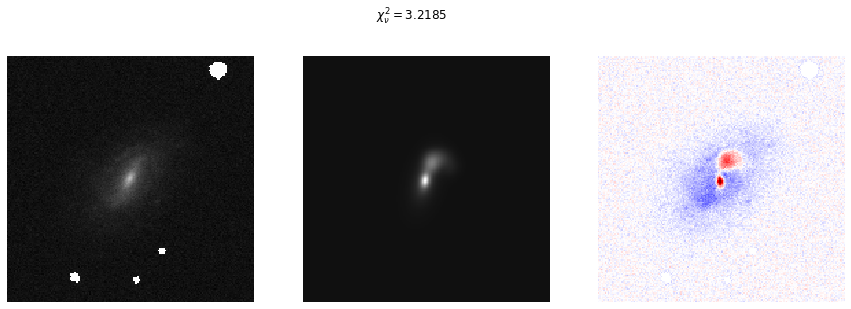

In [42]:
r = model_obj2.render()
kw = dict(
    cmap=asinh_cmap,
    vmin=min(data.min(), r.min()),
    vmax=max(data.max(), r.max())
)
f, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(data, **kw)
ax[1].imshow(r, **kw)
plot_difference(r - data, ax[2])
cq = fitting.chisq(r, data, sigma_image)
plt.suptitle(r'$\chi_\nu^2 = {:.4f}$'.format(cq))
[a.axis('off') for a in ax];

Perform the full optimization:

In [43]:
all_p2 = get_new_params(model_obj2.params.dropna())
with tqdm(leave=True) as pbar:
    def update_bar(*args):
        pbar.update(1)
        pbar.set_description(f'chisq={_func(args[0], model_obj2, lims_df, all_p2):.4f}')
    res = minimize(
        _func,
        all_p2.reindex_like(lims_df),
        args=(model_obj2, lims_df, all_p2),
        bounds=lims_df.values,
        callback=update_bar,
        options=dict(maxiter=100),
    )

chisq=69845.2927: : 3it [00:19,  6.38s/it]


KeyboardInterrupt: 

In [44]:
final_params = get_original_params(
    pd.Series(res['x'], index=lims_df.index).combine_first(all_p2)
).sort_index()

ValueError: Length of passed values is 13, index implies 16

In [45]:
r = model_obj2.render(params=final_params)
kw = dict(
    cmap=asinh_cmap,
    vmin=min(data.min(), r.min()),
    vmax=max(data.max(), r.max())
)
f, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(data, **kw)
ax[1].imshow(r, **kw)
plot_difference(r - data, ax[2])
cq = fitting.chisq(r, data, sigma_image)
plt.suptitle(r'$\chi_\nu^2 = {:.4f}$'.format(cq))
[a.axis('off') for a in ax];

NameError: name 'final_params' is not defined

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), dpi=100)
ax[0][0].imshow(model_obj.data, **kw)
ax[0][1].imshow(model_obj.render(model=model_dict), **kw)
ax[0][2].imshow(model_obj.render(params=final_params), **kw)
ax[1][1].imshow(model_obj.render(model=model_dict) - model_obj.data, vmin=-0.5, vmax=0.5, cmap='seismic')
ax[1][2].imshow(model_obj.render(params=final_params) - model_obj.data, vmin=-0.5, vmax=0.5, cmap='seismic')
[a.axis('off') for a in ax.ravel()];
plt.tight_layout()

In [ ]:
final_model_obj = fitting.Model(
    model_obj.to_dict(final_params),
    data,
    psf=psf,
    sigma_image=sigma_image,
)

How have these parameters changed from the initial conditions?

In [ ]:
(final_model_obj.sanitize().dropna() - parsing.to_pandas(model_dict)).unstack()

## Measuring bulge fraction:

In [ ]:
gzb_bt = np.sum(final_model_obj._cache['bulge'] + final_model_obj._cache['bar']) / final_model_obj.render().sum()

In [ ]:
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
lackner_nb1 = pd.read_csv('lib/lackner_nb1.csv', index_col=0)
lackner_nb4 = pd.read_csv('lib/lackner_nb4.csv', index_col=0)

In [ ]:
print(f'Galaxy Builder: {gzb_bt:.3f}')
print('Lackner nb1:')
print(lackner_nb1.loc[subject_id][['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']])
print('Lackner nb4:')
print(lackner_nb4.loc[subject_id][['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']])
print('Simard nb4:')
print(simard_df.loc[subject_id][['__B_T_r', 'e__B_T_r']])
print('Simard sersic:')
print(simard_df_free.loc[subject_id][['__B_T_r', 'e__B_T_r']])